In [1]:
import torch
import torch.nn as nn
import torch_geometric
from src.layer.wavelet_weights import WaveletCoefs
from src.layer.encoders import TrigonometricEncoder

<Axes: >

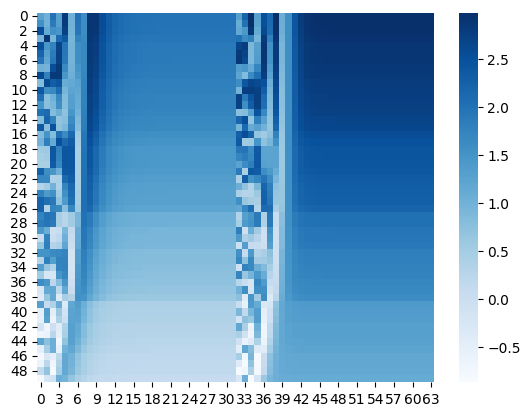

In [2]:
import numpy as np 
import seaborn as sns

eigvs = torch.tensor(np.random.uniform(0,2, (64,50) ),
                      dtype=torch.float32).sort(
    axis=1,descending=True).values
d = 64

pe = TrigonometricEncoder(d, 100, project=False)
pos = pe(eigvs)
sns.heatmap(pos.detach()[0], cmap='Blues')

In [3]:
coefs_function = WaveletCoefs(d, 0.01, 4)

In [4]:
coefs = coefs_function(eigvs)

In [24]:
coefs.mean(dim=-2).shape

torch.Size([64, 64])

In [26]:
coefs.shape

torch.Size([64, 50, 64])

In [ ]:
.shape

torch.Size([2, 10, 10])

In [21]:
eigvs.shape

torch.Size([64, 50])

In [22]:
torch.diag(eigvs)

tensor([1.9872, 1.9268, 1.9430, 1.8420, 1.7644, 1.7975, 1.6820, 1.2780, 1.7038,
        1.6211, 1.6084, 1.3440, 1.6320, 1.4956, 1.4769, 1.2723, 1.1492, 1.5077,
        1.0716, 1.2490, 1.0983, 1.0363, 1.3540, 0.8112, 1.0791, 1.1505, 0.8991,
        0.8413, 1.0056, 0.9492, 0.8631, 0.6798, 0.5834, 0.5698, 0.7075, 0.6570,
        0.3904, 0.6397, 0.4606, 0.3254, 0.5289, 0.2286, 0.2566, 0.2934, 0.1655,
        0.1095, 0.2888, 0.1039, 0.0291, 0.0062])

In [30]:
coefs.shape

torch.Size([64, 50, 64])

In [33]:
coefs.transpose(-2, -1).shape

torch.Size([64, 64, 50])